/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-04-06 00:21:07,835 INFO STARTED running simulations


Instructions for updating:
Colocations handled automatically by placer.


2019-04-06 00:21:08,165 WARNING From /state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-04-06 00:21:08,348 INFO Processing: bl_cd_pn_ag


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dense (Dense)                (None, 32, 32, 16)        528       
__________

Epoch 71/100
1/1 [==============================] - 0s 401ms/step - loss: 51.2439 - acc: 0.3124
Epoch 72/100
1/1 [==============================] - 0s 396ms/step - loss: 49.7654 - acc: 0.3173
Epoch 73/100
1/1 [==============================] - 0s 388ms/step - loss: 49.9339 - acc: 0.3224
Epoch 74/100
1/1 [==============================] - 0s 417ms/step - loss: 47.5541 - acc: 0.3388
Epoch 75/100
1/1 [==============================] - 0s 388ms/step - loss: 52.6005 - acc: 0.3599
Epoch 76/100
1/1 [==============================] - 0s 411ms/step - loss: 48.1784 - acc: 0.3951
Epoch 77/100
1/1 [==============================] - 0s 391ms/step - loss: 51.9066 - acc: 0.4194
Epoch 78/100
1/1 [==============================] - 0s 389ms/step - loss: 52.1900 - acc: 0.4463
Epoch 79/100
1/1 [==============================] - 0s 403ms/step - loss: 49.0963 - acc: 0.4583
Epoch 80/100
1/1 [==============================] - 0s 404ms/step - loss: 48.7613 - acc: 0.4641
Epoch 81/100
1/1 [======================

2019-04-06 00:21:50,744 DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-04-06 00:21:50,768 DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


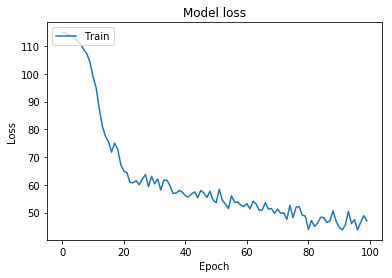

2019-04-06 00:21:51,321 DEBUG prediction output shape: (100, 32, 32, 3)
2019-04-06 00:21:51,418 INFO FINISHED running simulations


<Figure size 432x288 with 0 Axes>

2019-04-06 00:21:51,478 DEBUG backend module://ipykernel.pylab.backend_inline version unknown


In [1]:
%matplotlib inline


""" Training and test for model v0.2.1
This is a version which includes the augmented data. We're
using a different approach than the Sony model so we don't
have to use patching. RGB input image.
"""
import os
import logging
import pickle
from urllib.parse import urljoin

import numpy as np
import scipy.stats as sct
import tensorflow as tf
from tensorflow.train import AdamOptimizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from model02 import model02
from model_utils import enable_cloud_log, plot_images, plot_loss
from custom_loss import mean_absolute_error

logger = logging.getLogger(__name__)

# Helper functions

def read_pickle(fpath):
    with open(fpath, "rb") as infile:
        m = pickle.load(infile)
    return m

def bl(image, sample=False):
    """ Apply black level """
    
    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]  # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
       

    BL = int(sample[0])
    image[image < BL] = BL
    image = image - BL
    
        
    return image

def bl_cd(image, sample=False):
    """ Apply black level with color distortion """

    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]   # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    image = bl(image, sample)

    WB = [ sample[1], sample[2], sample[3] ]
    
    image[... ,0] = WB[0] * image[... ,0]
    image[... ,1] = WB[1] * image[... ,1]
    image[... ,2] = WB[2] * image[... ,2]

    return image

def bl_cd_pn(image, sample=False):
    """ Apply black level with color distortion and poisson noise. """
    
    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]    # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    noise_param = 10

    image = bl_cd(image, sample)

    noise = lambda x : np.random.poisson(x / 255.0 * noise_param) / \
        noise_param * 255

    func = np.vectorize(noise)
    image = func(image)
    return image

def bl_cd_pn_ag(image, sample=False):
    """ 
    Apply black level, color distortion, poisson noise, adjust gamma. 
    """

    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]   # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    image = bl_cd_pn(image, sample)
    image = image**sample[4]
    return image


# Create checkpoint callback

checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True,
                              period=5, verbose=1)


# Retrieve latest checkpoint if it exists

def fit_model(X_train, Y_train, model, checkpoint_dir, imgtup):

    imgname, imgfunc = imgtup
    
    chk = os.listdir(checkpoint_dir)
    if len(chk) > 1:
    #    latest = tf.train.latest_checkpoint(checkpoint_dir)
    #    model.load_weights(latest)
        pass

    else:
        datagen = ImageDataGenerator(
            preprocessing_function=imgfunc)

        # Transform all training images
        datagen.fit(X_train)

        # Compile model

        learning_rate = 1e-3
        opt = AdamOptimizer(learning_rate=learning_rate)

        model.compile(optimizer=opt,
                      loss=mean_absolute_error,
                      metrics=['accuracy'])

        model.summary()

        # Fit model

        history = model.fit_generator(datagen.flow(X_train,Y_train,
                                                   batch_size=100),    
                                      steps_per_epoch=X_train.shape[0] / 32,
                                      epochs=100)
        plot_loss('review/train_val_loss_021_{}.png'.format(imgname), history)

    return model

def model_predict(model, X_test, imgtup):

    imgname, imgfunc = imgtup

    X_noise_test = imgfunc(X_test)
    output = model.predict(X_noise_test)
    
    logger.debug("prediction output shape: {}".format(output.shape))

    return output

def review_image_output(X_test, Y_pred, Y_true, imgtup, every=10):
    # Review image output

    imgname, imgfunc = imgtup
    base = "review/"

    for i in range(Y_pred.shape[0]):

        if i % every == 0:

            name = urljoin(base, 'model_pred_{}_{}.png'.format(i, imgname))
            plot_images(name, imgfunc(X_test[i,...]), Y_pred[i, ...],
                        Y_true[i,...])


def run_simulation(fcov, fmean):

    logger.info("STARTED running simulations")

    # Dataset of 50,000 32x32 color training images, 
    # labeled over 10 categories, and 10,000 test images.

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    m = 100
    X_train = X_train[0:m,...]
    X_test = X_test[0:m,...]
    Y_train = np.copy(X_train)
    Y_test = np.copy(X_test)

    imgman = [
#         ('bl', bl),
#         ('bl_cd', bl_cd),
#         ('bl_cd_pn', bl_cd_pn),
        ('bl_cd_pn_ag', bl_cd_pn_ag),
    ]

    for imgtup in imgman:

        # Define model    
        model = model02()

        imgname, imgfunc = imgtup
        logger.info("Processing: {}".format(imgtup[0]))
        model = fit_model(X_train, Y_train, model, checkpoint_dir, imgtup)
        Y_pred = model_predict(model, X_test, imgtup)
        review_image_output(X_test, Y_pred, Y_test, imgtup, every=10)

        model = None

    logger.info("FINISHED running simulations")

if __name__ == "__main__":

    enable_cloud_log('DEBUG')
    
    fcov = "simulation_cov.pkl"
    fmean = "simulation_mean.pkl"

    COVM = read_pickle(fcov)
    MEANM = read_pickle(fmean)


    run_simulation(fcov, fmean)

